In [ ]:
import keras
import json
from keras.datasets import cifar10
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from matplotlib import pyplot as plt
import numpy as np
import os
import copy
import cv2
from scipy.ndimage import zoom
import imutils

In [ ]:
batch_size        = 64
epochs            = 20
num_classes       = 10
save_dir          = os.path.join(os.getcwd(), 'drive/My Drive/NEU/7150/Final Project/')
class_names       = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train_1 = keras.utils.to_categorical(y_train, num_classes)
y_test_1 = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
def getModel(filterSize, stride):
  model       = Sequential()
  model.name  = 'CNN_' + str(filterSize[0]) + '_' + str(stride[0])

  model.add(Conv2D(16, filterSize, strides= stride, padding='same', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

  model.add(Conv2D(32, filterSize, strides= stride, padding='same', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(Activation('relu'))

  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics= ['accuracy','mse'])

  model.summary()

  return model

In [ ]:
def getDatagen(x_train):
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
      featurewise_center=False,  # set input mean to 0 over the dataset
      samplewise_center=False,  # set each sample mean to 0
      featurewise_std_normalization=False,  # divide inputs by std of the dataset
      samplewise_std_normalization=False,  # divide each input by its std
      zca_whitening=False,  # apply ZCA whitening
      zca_epsilon=1e-06,  # epsilon for ZCA whitening
      rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
      # randomly shift images horizontally (fraction of total width)
      width_shift_range=0.1,
      # randomly shift images vertically (fraction of total height)
      height_shift_range=0.1,
      shear_range=0.,  # set range for random shear
      zoom_range=0.,  # set range for random zoom
      channel_shift_range=0.,  # set range for random channel shifts
      # set mode for filling points outside the input boundaries
      fill_mode='nearest',
      cval=0.,  # value used for fill_mode = "constant"
      horizontal_flip=True,  # randomly flip images
      vertical_flip=False,  # randomly flip images
      # set rescaling factor (applied before any other transformation)
      rescale=None,
      # set function that will be applied on each input
      preprocessing_function=None,
      # image data format, either "channels_first" or "channels_last"
      data_format=None,
      # fraction of images reserved for validation (strictly between 0 and 1)
      validation_split=0.0)

  datagen.fit(x_train)

  return datagen

In [ ]:
filterSizes   = [(11,11),(7,7),(5,5),(3,3)]
strides       = [(1,1),(2,2)]
histories     = {}
models        = {}
modelFolder   = save_dir + 'Models/'
historyFolder = save_dir + 'Histories/'

# set reTrain as True to re-train all models

reTrain       = False

for filterSize in filterSizes:
  for stride in strides:
    histories[(filterSize,stride)]  = None
    models[(filterSize,stride)]     = None

In [ ]:
if reTrain == True:
  for filterSize in filterSizes:
    for stride in strides:
      print('FilterSize and Stride for current model - ',filterSize,stride)
      datagen = getDatagen(x_train)
      model   = getModel(filterSize, stride)
      history = model.fit_generator(datagen.flow(x_train, y_train_1,batch_size=batch_size),
                      epochs=epochs,
                      validation_data=(x_test, y_test_1),
                      workers=4)
      histories[(filterSize,stride)]  = history
      models[(filterSize,stride)]     = model


In [ ]:
if reTrain == True:
  for key, model in models.items():
    if not os.path.isdir(modelFolder):
        os.makedirs(modelFolder)

    model_path = os.path.join(modelFolder, str(model.name+'.h5'))
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

In [ ]:
if reTrain == True:
  for key, history in histories.items():
    if not os.path.isdir(historyFolder):
        os.makedirs(historyFolder)

    history_path = os.path.join(historyFolder, str(models[key].name+'.txt'))

    text_file = open(history_path, "w")
    text_file.write(str(history.history))
    text_file.close()

In [ ]:
if reTrain == False:
  for key, model in models.items():
    modelName   = 'CNN_'+str(key[0][0])+'_'+str(key[1][0])+'.h5'
    path        = modelFolder+modelName
    models[key] = keras.models.load_model(path)

In [ ]:
if reTrain == False:
  for key, history in histories.items():
    history_path    = os.path.join(historyFolder, str(models[key].name+'.txt'))
    history         = open(history_path, 'r')
    history         = history.read()
    history         = history.replace("'",'"')
    history         = json.loads(history)
    histories[key]  = history

Plot the accuracy of the different models

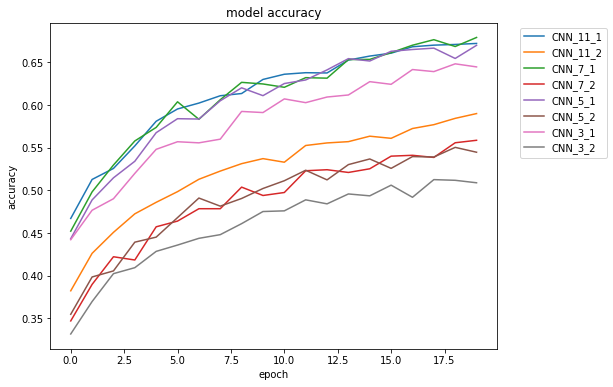

In [ ]:
fig=plt.figure(figsize=(8, 6))

legend = []
for key, history in histories.items():
  plt.plot(history['val_accuracy'])
  legend.append(models[key].name)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(legend, bbox_to_anchor=(1.04,1), loc='upper left')
plt.show()

In [ ]:
def displayActivations(trainedModel, testImage, title, cMap = 'viridis'):
  noOfLayers  = len(trainedModel.layers)
  imgIndex    = 1
  fig         = plt.figure(figsize=(16, 10))

  for layerIndex in range(noOfLayers):
    layer = trainedModel.layers[layerIndex]

    if 'conv' not in layer.name:
      continue
    
    # print(layerIndex, layer.name, layer.output.shape)

    layerModel  = Model(inputs=trainedModel.inputs, outputs=trainedModel.layers[layerIndex].output)
    features    = layerModel.predict(testImage)

    numberOfFeatures = len(features[0,0,0,:])

    maxActivationIndex  = None
    maxNorm             = None

    for i in range(1,numberOfFeatures):
      currNorm = np.linalg.norm(features[0,:,:,i])
      if maxNorm is None or currNorm > maxNorm:
        maxNorm             = currNorm
        maxActivationIndex  = i

    maxActivation = features[0,:,:,maxActivationIndex]
    axs1          = fig.add_subplot((int)(np.ceil(noOfLayers/2)), 4, imgIndex)
    axs1.set_title('Max Activation of layer ' + str(layerIndex))
    plt.imshow(maxActivation, cmap=cMap)
    #plt.colorbar()
    imgIndex      = imgIndex + 1

    mean = None
    for i in range(numberOfFeatures):
      if mean is None:
        mean = copy.deepcopy(features[0,:,:,i])
      else:
        mean += features[0,:,:,i]

    mean      = mean/numberOfFeatures
    axs2      = fig.add_subplot((int)(np.ceil(noOfLayers/2)), 4, imgIndex)
    axs2.set_title('Mean Activation of layer ' + str(layerIndex))
    plt.imshow(mean, cmap=cMap)
    #plt.colorbar()
    imgIndex  = imgIndex + 1

  plt.suptitle(title)
  plt.show()

Test Image

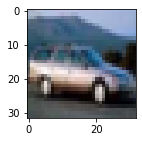

In [ ]:
fig = plt.figure(figsize=(2,2))

plt.imshow(x_train[4])

In [ ]:
def displayAllActivations(trainedModel, img, layerIndex, title, cMap = 'gray'):
  layer = trainedModel.layers[layerIndex]
  if 'conv' not in layer.name:
    print('Not a convolutional layer.')
    return

  layerModel  = Model(inputs=trainedModel.inputs, outputs=trainedModel.layers[layerIndex].output)
  features    = layerModel.predict(img)
  features    = features[0]

  cols = 4
  rows = int(np.ceil(len(features[0,0,:])/cols))

  fig = plt.figure(figsize=(cols+1, rows+2))

  for index in range(len(features[0,0,:])):
    fig.add_subplot(rows, cols, index+1)
    plt.axis('off')
    plt.imshow(features[:,:,index], cmap = cMap)
  
  plt.suptitle(title)

Display activations for different stride configurations from different layers

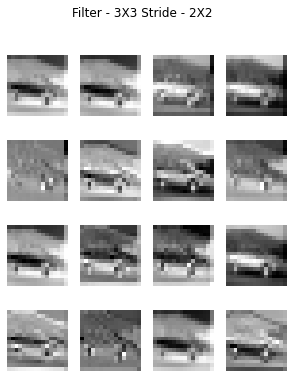

In [ ]:
displayAllActivations(models[((3,3),(2,2))], x_train[4:5], 0, 'Filter - 3X3 Stride - 2X2')

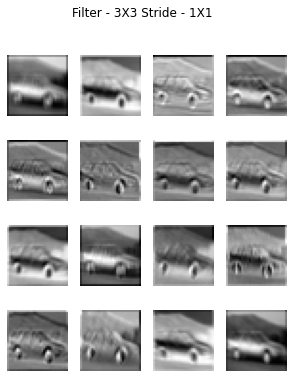

In [ ]:
displayAllActivations(models[((3,3),(1,1))], x_train[4:5], 0, 'Filter - 3X3 Stride - 1X1')

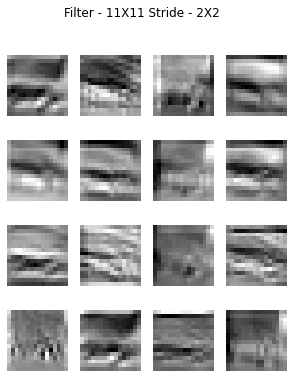

In [ ]:
displayAllActivations(models[((11,11),(2,2))], x_train[4:5], 0, 'Filter - 11X11 Stride - 2X2')

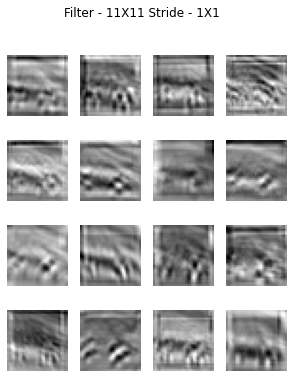

In [ ]:
displayAllActivations(models[((11,11),(1,1))], x_train[4:5], 0, 'Filter - 11X11 Stride - 1X1')

Display the max and mean activations from top-most and bottom-most layers of the models

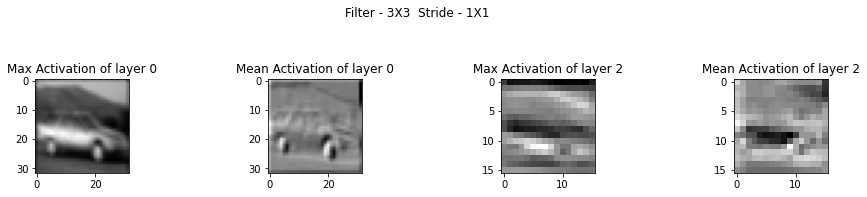

In [ ]:
displayActivations(models[((3, 3), (1, 1))], x_train[4:5], 'Filter - 3X3  Stride - 1X1', 'gray')

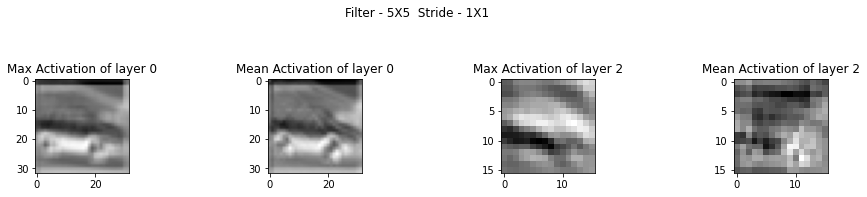

In [ ]:
displayActivations(models[((5, 5), (1, 1))], x_train[4:5], 'Filter - 5X5  Stride - 1X1', 'gray')

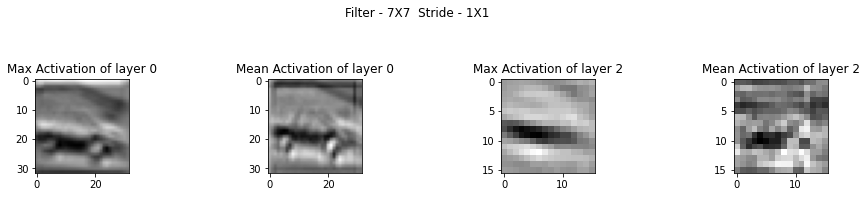

In [ ]:
displayActivations(models[((7, 7), (1, 1))], x_train[4:5], 'Filter - 7X7  Stride - 1X1', 'gray')

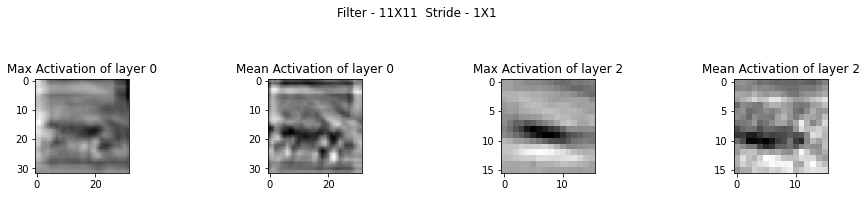

In [ ]:
displayActivations(models[((11, 11), (1, 1))], x_train[4:5], 'Filter - 11X11  Stride - 1X1', 'gray')

In [ ]:
accuracy = {}
for key, model in models.items():
  scores    = model.evaluate(x_test, y_test_1, verbose=1)
  accuracy[key] = scores

10000/10000 [==============================] - 1s 131us/step


Loss and Accuracy of all models

In [ ]:
for key, data in accuracy.items():
  print('Model:', models[key].name)
  print('Test loss:', accuracy[key][0])
  print('Test accuracy:', accuracy[key][1])

Model: CNN_11_1
Test loss: 0.9552609617233276
Test accuracy: 0.6722000241279602
Model: CNN_11_2
Test loss: 1.1576199140548706
Test accuracy: 0.5899999737739563
Model: CNN_7_1
Test loss: 0.9296833701133728
Test accuracy: 0.6791999936103821
Model: CNN_7_2
Test loss: 1.2339280975341798
Test accuracy: 0.5587000250816345
Model: CNN_5_1
Test loss: 0.9454469275474549
Test accuracy: 0.6700000166893005
Model: CNN_5_2
Test loss: 1.2741846885681152
Test accuracy: 0.544700026512146
Model: CNN_3_1
Test loss: 1.013517101287842
Test accuracy: 0.6446999907493591
Model: CNN_3_2
Test loss: 1.3687524740219117
Test accuracy: 0.508899986743927
